<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/rbm-raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import minmax_scale

rc = {
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 14,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
}
sns.set('notebook', 'whitegrid', rc=rc)

## Model

### Energy-based Models

Given a training samples $\mathbf{v}$, our goal is learn a distribution for it $p(\mathbf{v})$. To do this, we can use energy-based models, by associating a scalar energy score $E(v)$ to each training sample, while small energy scores correspond to high probabilties and large scores correspond to low probabilities.

$$p(\mathbf{v}) = \frac{e^{-E(\mathbf{v})}}{Z}$$

where the exponential is to ensure positivity, and $Z$ is called **partition function** as normalizing constant to ensure intergration of 1:

$$Z=\sum_\mathbf{v} e^{-E(\mathbf{v})}$$

### Restricted Boltzmann Machines

Restricted Boltzmann Machines are a particular form of log-linear Markov Random Field (MRF). It consists of $m$ visible unites $\mathbf{v}=(v_1,v_2,\ldots,v_m)$ and $n$ hidden units $\mathbf{h} = (h_1,h_2,\ldots,h_n)$. 

Here is the graphical depiction:

<img src="./images/rbm.png" align="center"/>

The joint distribution is given by the Gibbs distribution

$$
p(\mathbf{v},\mathbf{h}) = \frac{e^{-E(\mathbf{v},\mathbf{h})}}{Z}
$$

$$
Z = \sum_\mathbf{v} \sum_\mathbf{h} e^{-E(\mathbf{v},\mathbf{h})}
$$

The energy function is defined as

$$
\begin{aligned}
E(\mathbf{v},\mathbf{h}) 
&= -\mathbf{v}^\intercal W\mathbf{h} - \mathbf{b}^\intercal \mathbf{v} - \mathbf{c}^\intercal \mathbf{h} \\
&= -\sum_{i=1}^m\sum_{j=1}^n w_{ij}v_ih_j - \sum_{i=1}^m b_i v_i - \sum_{j=1}^n c_j h_j
\end{aligned}
$$

The marginal distribution

$$
\begin{aligned}
p(\mathbf{v}) &= \frac{1}{Z} \sum_{\mathbf{h} \in \{0,1\}^n} \exp(\mathbf{v}^\intercal W \mathbf{h} + \mathbf{b}^\intercal \mathbf{v} + \mathbf{c}^\intercal\mathbf{h}) \\
&= \frac{1}{Z} \exp(\mathbf{b}^\intercal \mathbf{v}) \sum_{\mathbf{h}_1} \cdots \sum_{\mathbf{h}_n} \exp\left(\sum_j^n \mathbf{v}^\intercal W_{\cdot j} h_j + c_j h_j\right) \\
&= \frac{1}{Z} \exp(\mathbf{b}^\intercal \mathbf{v}) \sum_{\mathbf{h}_1} \cdots \sum_{\mathbf{h}_n} \prod_j^n \exp( \mathbf{v}^\intercal W_{\cdot j} h_j + c_j h_j) \\
&= \frac{1}{Z} \exp(\mathbf{b}^\intercal \mathbf{v}) \left(\sum_{h_1}\exp(\mathbf{v}^\intercal W_{\cdot 1} h_1 + c_1 h_1)\right) \cdots \left(\sum_{h_n}\exp(\mathbf{v}^\intercal W_{\cdot n} h_n + c_n h_n)\right) \\
&= \frac{1}{Z} \exp(\mathbf{b}^\intercal \mathbf{v}) \big(1 +\exp(\mathbf{v}^\intercal W_{\cdot 1} + c_1)\big) \cdots \big(1 +\exp(\mathbf{v}^\intercal W_{\cdot n} + c_n)\big) \\
&= \frac{1}{Z} \exp(\mathbf{b}^\intercal \mathbf{v}) \exp\Big(\log\big(1 +\exp(\mathbf{v}^\intercal W_{\cdot 1} + c_1)\big)\Big) \cdots \exp\Big(\log\big(1 +\exp(\mathbf{v}^\intercal W_{\cdot n} + c_n)\big)\Big) \\
&= \frac{1}{Z} \exp\Big(\mathbf{b}^\intercal \mathbf{v}+\sum_j^n \log\big(1 +\exp(\mathbf{v}^\intercal W_{\cdot j} + c_j)\big)\Big) \\
&= \frac{e^{-\mathcal{F}(\mathbf{v})}}{Z}
\end{aligned}
$$

Where $\mathcal{F}$ is called **free energy**

$$
\mathcal{F}(\mathbf{v}) = -\mathbf{b}^\intercal \mathbf{v}-\sum_j^n \log\big(1 +\exp(\mathbf{v}^\intercal W_{\cdot j} + c_j)\big)
$$

In [2]:
def free_energy(v, W, b, c):
    first = v @ b.T
    second = (np.log(1 + np.exp(v @ W + c))).sum(axis=1,keepdims=True)
    return - first - second

Conditional distribution

$$
\begin{aligned}
p(\mathbf{h}\mid \mathbf{v}) &= \frac{p(\mathbf{v},\mathbf{h})}{p(\mathbf{v})} \\
&= \frac{p(\mathbf{v},\mathbf{h})}{\sum\limits_h p(\mathbf{v},\mathbf{h})} \\
&= \frac{\frac{1}{Z}\exp(-E(\mathbf{v},\mathbf{h}))}{\sum\limits_h \frac{1}{Z}\exp(-E(\mathbf{v},\mathbf{h}))} \\
&= \frac{\exp(\mathbf{v}^\intercal W\mathbf{h} + \mathbf{b}^\intercal \mathbf{v} + \mathbf{c}^\intercal \mathbf{h})}{\sum\limits_h \exp(\mathbf{v}^\intercal W\mathbf{h} + \mathbf{b}^\intercal \mathbf{v} + \mathbf{c}^\intercal \mathbf{h})} \\
&= \frac{\exp(\mathbf{v}^\intercal W\mathbf{h})\exp(\mathbf{b}^\intercal \mathbf{v})\exp (\mathbf{c}^\intercal \mathbf{h})}{\sum\limits_h \exp(\mathbf{v}^\intercal W\mathbf{h})\exp(\mathbf{b}^\intercal \mathbf{v})\exp (\mathbf{c}^\intercal \mathbf{h})} \\
&= \frac{\exp(\mathbf{v}^\intercal W\mathbf{h})\exp (\mathbf{c}^\intercal \mathbf{h})}{\sum\limits_h \exp(\mathbf{v}^\intercal W\mathbf{h})\exp (\mathbf{c}^\intercal \mathbf{h})} \\
&= \frac{1}{Z\prime}\exp(\mathbf{v}^\intercal W\mathbf{h})\exp (\mathbf{c}^\intercal \mathbf{h}) \\
&= \frac{1}{Z\prime}\exp\big(\sum_{j=1}^n\mathbf{v}^\intercal W_{\cdot j} h_j + \sum_{j=1}^n c_j h_j\big) \\
&= \frac{1}{Z\prime} \prod_{j=1}^n \exp(\mathbf{v}^\intercal W_{\cdot j} h_j + c_j h_j) \\
&= \frac{1}{Z\prime} \prod_{j=1}^n p\prime(h_j \mid \mathbf{v})
\end{aligned}
$$

where $p\prime(h_j \mid \mathbf{v})$ are unnormalized distribution over the individual elements $h_j$, and this tells us the hidden units are independent. 

When $\mathbf{h} \in \{0,1\}^n$

$$
\begin{aligned}
p(h_j =1 \mid \mathbf{v}) &= \frac{p\prime(h_j=1,\mathbf{v})}{p\prime(h_j=0,\mathbf{v}) + p\prime(h_j=1,\mathbf{v})} \\
&= \frac{\exp(\mathbf{v}^\intercal W_{\cdot j} + c_j)}{\exp(0) + \exp(\mathbf{v}^\intercal W_{\cdot j} + c_j)} \\
&= sigmoid(\mathbf{v}^\intercal W_{\cdot j} + c_j)
\end{aligned}
$$

for the visible units

$$
p(v_i =1 \mid \mathbf{h}) = sigmoid(W_{i \cdot} \mathbf{h} + b_j)
$$

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def h_given_v(v, W, c):
    return sigmoid(v @ W + c)

def v_given_h(h, W, b):
    return sigmoid(h @ W.T + b)

### Loss Function

With the model parameters $\theta = \{W,\mathbf{b},\mathbf{c}\}$ and a training sample $\mathbf{v}^{(t)}$,  we can use the negative log-likelihood as the loss function

$$
\begin{aligned}
\mathscr{l}(\theta) &= -\log p(\mathbf{v}^{(t)}) \\
&= -\log \sum_{\mathbf{h}} p(\mathbf{v}^{(t)}, \mathbf{h}) \\
&= -\log \frac{1}{Z} \sum_{\mathbf{h}} \exp\big(-E(\mathbf{v}^{(t)},\mathbf{h})\big) \\
&= -\log \sum_{\mathbf{h}} \exp\big(-E(\mathbf{v}^{(t)},\mathbf{h})\big) + \log Z \\
&= -\log \sum_{\mathbf{h}} \exp\big(-E(\mathbf{v}^{(t)},\mathbf{h})\big) + \log \sum_{\mathbf{v},\mathbf{h}} \exp\big(-E(\mathbf{v},\mathbf{h})\big)
\end{aligned}
$$

Taking derivative, we have

$$
\nabla_\theta \mathscr{l}(\theta) = \underbrace{\nabla_\theta -\log \sum_{\mathbf{h}} \exp(-E(\mathbf{v}^{(t)},\mathbf{h}))}_{\text{positive phase}} + \underbrace{\nabla_\theta \log \sum_{\mathbf{v},\mathbf{h}} \exp(-E(\mathbf{v},\mathbf{h}))}_{\text{negative phase}}
$$

for **positive phase**

$$
\begin{aligned}
\nabla_\theta -\log \sum_{\mathbf{h}} \exp\big(-E(\mathbf{v}^{(t)},\mathbf{h})\big) &= -\frac{1}{\sum_{\mathbf{h}} \exp(-E(\mathbf{v}^{(t)},\mathbf{h}))} \sum_h \exp(-E(\mathbf{v}^{(t)},\mathbf{h})) \frac{\partial -E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \\
&= - \sum_h \frac{\exp(-E(\mathbf{v}^{(t)},\mathbf{h}))}{\sum_{\mathbf{h}} \exp(-E(\mathbf{v}^{(t)},\mathbf{h})} \frac{\partial -E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \\
&= - \sum_h \frac{\frac{\exp(-E(\mathbf{v}^{(t)},\mathbf{h}))}{Z}}{\frac{\sum_{\mathbf{h}} \exp(-E(\mathbf{v}^{(t)},\mathbf{h})}{Z}} \frac{\partial -E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \\
&= - \sum_h \frac{p(\mathbf{v}^{(t)},\mathbf{h})}{p(\mathbf{v}^{(t)})} \frac{\partial -E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \\
&= - \sum_h p(\mathbf{h} \mid \mathbf{v}^{(t)}) \frac{\partial -E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \\
&= \mathbb{E}_\mathbf{h}\left[ \frac{\partial E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \middle| \mathbf{v}^{(t)} \right]
\end{aligned}
$$

for **negative phase**

$$
\begin{aligned}
\nabla_\theta \log \sum_{\mathbf{v},\mathbf{h}} \exp\big(-E(\mathbf{v},\mathbf{h})\big) &= \frac{1}{\sum_{\mathbf{v},\mathbf{h}} \exp(-E(\mathbf{v},\mathbf{h}))} \sum_{\mathbf{v},\mathbf{h}}\exp(-E(\mathbf{v},\mathbf{h})) \frac{\partial -E(\mathbf{v},\mathbf{h})}{\partial \theta} \\
&= \sum_{\mathbf{v},\mathbf{h}} \frac{\exp(-E(\mathbf{v},\mathbf{h}))}{\sum_{\mathbf{v},\mathbf{h}} \exp(-E(\mathbf{v},\mathbf{h}))} \frac{\partial -E(\mathbf{v},\mathbf{h})}{\partial \theta} \\
&= \sum_{\mathbf{v},\mathbf{h}} \frac{\frac{\exp(-E(\mathbf{v},\mathbf{h}))}{Z}}{\frac{\sum_{\mathbf{v},\mathbf{h}} \exp(-E(\mathbf{v},\mathbf{h}))}{Z}} \frac{\partial -E(\mathbf{v},\mathbf{h})}{\partial \theta} \\
&= \sum_{\mathbf{v},\mathbf{h}} p(\mathbf{v},\mathbf{h}) \frac{\partial -E(\mathbf{v},\mathbf{h})}{\partial \theta} \\
&= - \mathbb{E}_{\mathbf{v},\mathbf{h}}\left[\frac{\partial E(\mathbf{v},\mathbf{h})}{\partial \theta}\right]
\end{aligned}
$$

So the gradient is

$$
\nabla_\theta \mathscr{l}(\theta) = \mathbb{E}_{\mathbf{h}}\left[ \frac{\partial E(\mathbf{v}^{(t)},\mathbf{h})}{\partial \theta} \middle| \mathbf{v}^{(t)} \right] - \mathbb{E}_{\mathbf{v},\mathbf{h}}\left[\frac{\partial E(\mathbf{v},\mathbf{h})}{\partial \theta}\right]
$$

For each parameter, the gradients of energy function are

$$
\nabla_W E(\mathbf{v}, \mathbf{h}) = \frac{\partial}{\partial W} - \mathbf{v}^\intercal W \mathbf{h} - \mathbf{b}^\intercal \mathbf{v} - \mathbf{c}^\intercal \mathbf{h} = - \mathbf{h} \mathbf{v}^\intercal
$$

$$
\nabla_\mathbf{b} E(\mathbf{v}, \mathbf{h}) = \frac{\partial}{\partial \mathbf{b}} -\mathbf{v}^\intercal W \mathbf{h} - \mathbf{b}^\intercal \mathbf{v} - \mathbf{c}^\intercal \mathbf{h} = - \mathbf{v}
$$

$$
\nabla_\mathbf{c} E(\mathbf{v}, \mathbf{h}) = \frac{\partial}{\partial \mathbf{c}} -\mathbf{v}^\intercal W \mathbf{h} - \mathbf{b}^\intercal \mathbf{v} - \mathbf{c}^\intercal \mathbf{h} = - \mathbf{h}
$$

### Contrastive Divergence

The negative phase is intractable, we have to approximate it. The idea is 

1. run a $k$ step gibbs sampling to obtain a negative sample of the visible units $\tilde{\mathbf{v}}$
2. replace the expectation by a point estimate at $\tilde{\mathbf{v}}$

$$
\mathbb{E}_{\mathbf{v},\mathbf{h}}[\nabla_\theta E(\mathbf{v},\mathbf{h})] 
\approx \nabla_\theta E(\mathbf{v},\mathbf{h}) \mid_{\mathbf{v}=\tilde{\mathbf{v}},\mathbf{h}=\tilde{\mathbf{h}}}
$$

The gibbs sampling process is

1. $\mathbf{h}^{(k)} \sim p(\mathbf{h} \mid \mathbf{v}^{(k)})$
2. $\mathbf{v}^{(k+1)} \sim p(\mathbf{v} \mid \mathbf{h}^{(k)})$

Now update rule of $W$ becomes

$$
\begin{aligned}
W &\Leftarrow W - \eta \big(\nabla_W - \log p(\mathbf{v}^{(t)})\big) \\
&\Leftarrow W - \eta \left(\mathbb{E}_\mathbf{h}\big[ \nabla_W E(\mathbf{v}^{(t)}, \mathbf{h}) \mid \mathbf{v}^{(t)} \big] - \mathbb{E}_{\mathbf{v},\mathbf{h}} [\nabla_W E(\mathbf{v},\mathbf{h})] \right) \\
&\Leftarrow W - \eta \left(\mathbb{E}_\mathbf{h}\big[ \nabla_W E(\mathbf{v}^{(t)}, \mathbf{h}) \mid \mathbf{v}^{(t)} \big] - \mathbb{E}_{\tilde{\mathbf{h}}} [\nabla_W E(\tilde{\mathbf{v}},\tilde{\mathbf{h}}) \mid \tilde{\mathbf{v}}] \right) \\
&\Leftarrow W - \eta \left(\mathbb{E}_\mathbf{h}\big[ -\mathbf{h}{\mathbf{v}^{(t)}}^\intercal \mid \mathbf{v}^{(t)} \big] - \mathbb{E}_\tilde{\mathbf{h}}\big[ -\tilde{\mathbf{h}}\tilde{\mathbf{v}}^\intercal \mid \tilde{\mathbf{v}} \big] \right) \\
&\Leftarrow W + \eta \left(sigmoid({\mathbf{v}^{(t)}}^\intercal W + \mathbf{c}) {\mathbf{v}^{(t)}}^\intercal - sigmoid(\tilde{\mathbf{v}}^\intercal W + \mathbf{c}) \tilde{\mathbf{v}}^\intercal \right)
\end{aligned}
$$

Similarly

$$\mathbf{b} \Leftarrow \mathbf{b} + \eta (\mathbf{v}^{(t)} - \tilde{\mathbf{v}})$$

$$\mathbf{c} \Leftarrow \mathbf{c} + \eta \big(sigmoid({\mathbf{v}^{(t)}}^\intercal W + \mathbf{c}) - sigmoid(\tilde{\mathbf{v}}^\intercal W + \mathbf{c})\big)$$

In [4]:
def bernoulli(p):
    return np.floor(p + np.random.uniform(size=p.shape))

def cd_k(v, W, b, c, k=1):
    h_p = h_given_v(v, W, c)
    h = bernoulli(h_p)
    
    neg_v_p = v_given_h(h, W, b)
    neg_v = bernoulli(neg_v_p)
    neg_h_p = h_given_v(neg_v, W, c)
    neg_h = bernoulli(neg_h_p)
    
    for _ in range(k-1):
        neg_v_p = v_given_h(neg_h, W, b)
        neg_v = bernoulli(neg_v_p)
        neg_h_p = h_given_v(neg_v, W, c)
        neg_h = bernoulli(neg_h_p)
    
    dw = v.T @ h_p - neg_v.T @ neg_h_p
    db = v - neg_v
    dc = h - neg_h
    
    return dw, db, dc

### Pseudo-likelihood

Since the loss function is intractable, to track the training process, we use a metric called **pseudo-likelihood**. 

It works by randomly corrupt one bit of the sample $\tilde{\mathbf{v}}$, then compute the logistic of the difference of free energy

$$
\log PL(\mathbf{v}) \approx N \log\Big(sigmoid\big(\mathscr{F}(\tilde{\mathbf{v}}) - \mathscr{F}(\mathbf{v})\big)\Big)
$$

In [5]:
def pseudo_likelihook(v, W, b, c):
    ind = (np.arange(v.shape[0]), np.random.randint(0, v.shape[1], v.shape[0]))
    v_ = v.copy()
    v_[ind] = 1 - v_[ind]
    fe  = free_energy(v, W, b, c)
    fe_ = free_energy(v_, W, b, c)
    return (v.shape[0] * np.log(sigmoid(fe_ - fe))).mean(axis=0)

## Data

In [6]:
data, target = fetch_openml('mnist_784', version=1, return_X_y=True)

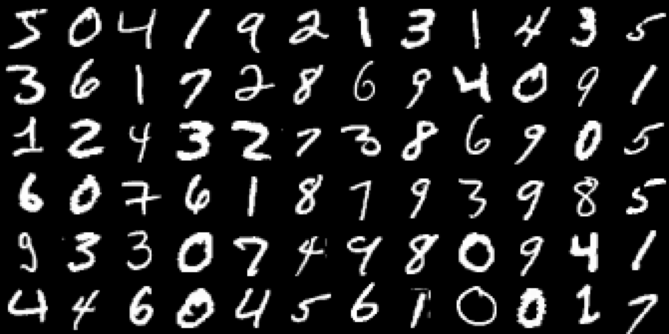

In [19]:
size, dim = 28, np.array([6,12])

fig, ax = plt.subplots(figsize=(6,4))

img = np.zeros(dim * size, dtype='uint8')
for i, d in enumerate(data[:dim.prod()]):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size, iy*size:(iy+1)*size] = d.reshape(28,28)

ax.imshow(img, cmap="gray")
ax.set_axis_off()
with plt.rc_context({"savefig.pad_inches": 0}):
#     plt.savefig('rmb-raw-01.png',bbox_inches='tight',dpi=96)
    plt.show()

## Train

In [8]:
def xavier_init(fan_in, fan_out, const=1.0):
    k = const * np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-k, k, (fan_in, fan_out))

In [9]:
train_ds = data.astype(np.float32) / 255.0

In [10]:
batch_size = 64
n_batch = (data.shape[0] + batch_size - 1) // batch_size # ceil
n_epoch = 10
n_vis, n_hid = 784, 64
lr = 0.1
k = 1

params = {
    "W": xavier_init(n_vis, n_hid),
    "b": np.zeros([1, n_vis]),
    "c": np.zeros([1, n_hid])
}

In [12]:
for e in range(n_epoch):
    cost = []
    for v in np.array_split(train_ds, n_batch):
        dw, db, dc = cd_k(v, params['W'], params['b'], params['c'], k)
        params['W'] += (lr / v.shape[0]) * dw
        params['b'] += (lr / v.shape[0]) * db.sum(axis=0)
        params['c'] += (lr / v.shape[0]) * dc.sum(axis=0)
        cost.append(pseudo_likelihook(v, params['W'], params['b'], params['c']))
        
    print("Epoch: {} cost: {:.6f}".format(e, np.mean(cost)))

Epoch: 0 cost: -10.212753
Epoch: 1 cost: -8.183398
Epoch: 2 cost: -7.647802
Epoch: 3 cost: -7.483645
Epoch: 4 cost: -7.359071
Epoch: 5 cost: -7.193161
Epoch: 6 cost: -6.994519
Epoch: 7 cost: -6.987463
Epoch: 8 cost: -6.917506
Epoch: 9 cost: -7.007021


## Results

In [13]:
def gibbs(v, W, b, c, k=1):
    h = bernoulli(h_given_v(v, W, c))
    for _ in range(k):
        v = v_given_h(h, W, b)
        h = bernoulli(h_given_v(bernoulli(v), W, c))
    return v

images = train_ds[:batch_size]
v = gibbs(images, params['W'], params['b'], params['c'], k)

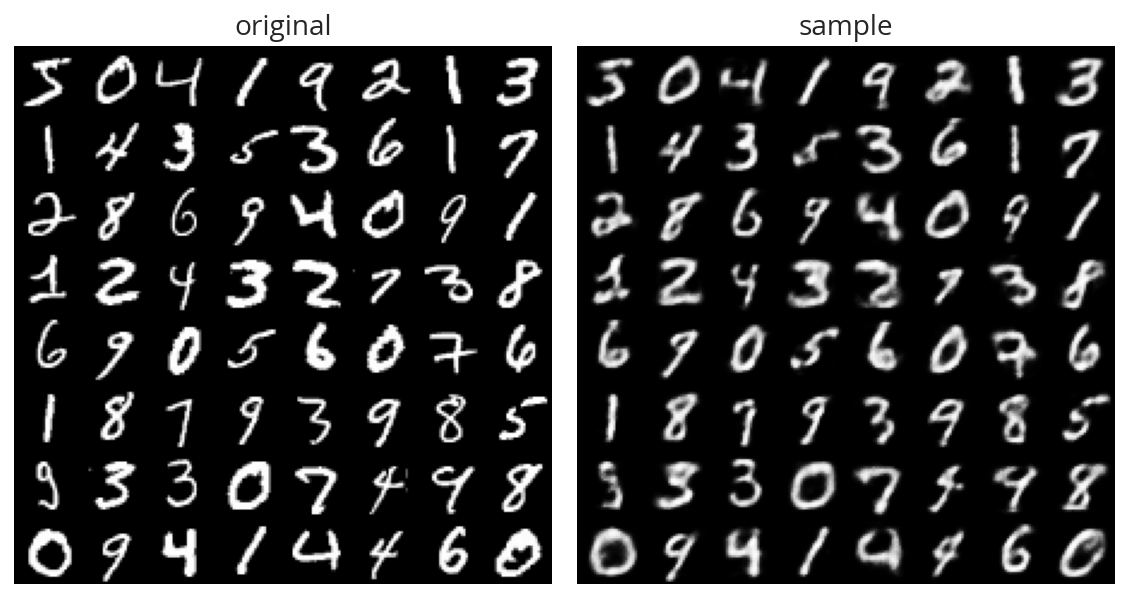

In [20]:
size, dim = 28, np.array([8,8])

fig, ax = plt.subplots(1, 2, figsize=(8,5))

img = np.zeros(dim * size, dtype=np.float32)
for i in range(dim.prod()):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size, iy*size:(iy+1)*size] = images[i].reshape((28,28))
ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[0].set(title="original")
    
img = np.zeros(dim * size, dtype=np.float32)
for i in range(dim.prod()):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size, iy*size:(iy+1)*size] = v[i].reshape((28,28))
ax[1].imshow(img, cmap="gray")
ax[1].set_axis_off()
ax[1].set(title="sample")

plt.tight_layout()
# plt.savefig('rmb-raw-02.png',bbox_inches='tight',dpi=96)
plt.show()

In [15]:
W = minmax_scale(params['W'])

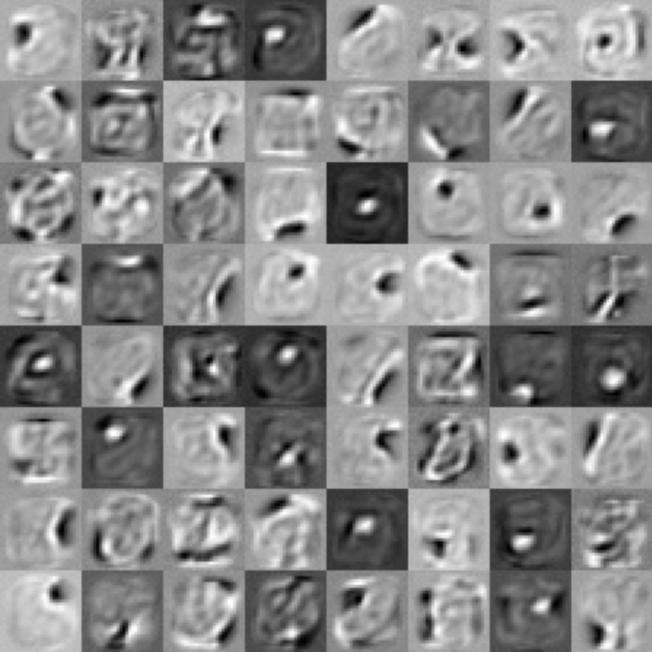

In [21]:
dim = np.array([8, 8])
fig, ax = plt.subplots(figsize=(6, 6))

img = np.zeros(dim * size, dtype=np.float32)
for i in range(dim.prod()):
    x, y = divmod(i, dim[1])
    img[x*size:(x+1)*size, y*size:(y+1)*size] = W[:,i].reshape(28,28)
ax.imshow(img, cmap="gray")
ax.set_axis_off()

with plt.rc_context({"savefig.pad_inches": 0}):
#     plt.savefig('rmb-raw-03.png',bbox_inches='tight',dpi=96)
    plt.show()

## References

* [A Tutorial on Energy-Based Learning](http://yann.lecun.com/exdb/publis/pdf/lecun-06.pdf)
* [Restricted Boltzmann Machines (RBM)](http://deeplearning.net/tutorial/rbm.html)
* [A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)